### Importing Libraries

In [1]:
"""""
The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

skin_df = pd.read_csv('/kaggle/input/skin-cancer-lesions-inzip/HAM10000_metadata.csv')
print(skin_df)

2024-04-14 08:23:54.669427: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-14 08:23:54.669529: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-14 08:23:54.830497: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


### Label Encoding to numeric values from text

In [2]:
SIZE=65

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [3]:
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extremity      5  
8984  lower extremity      5  
2310 

/tmp/ipykernel_34/3885637716.py:21: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


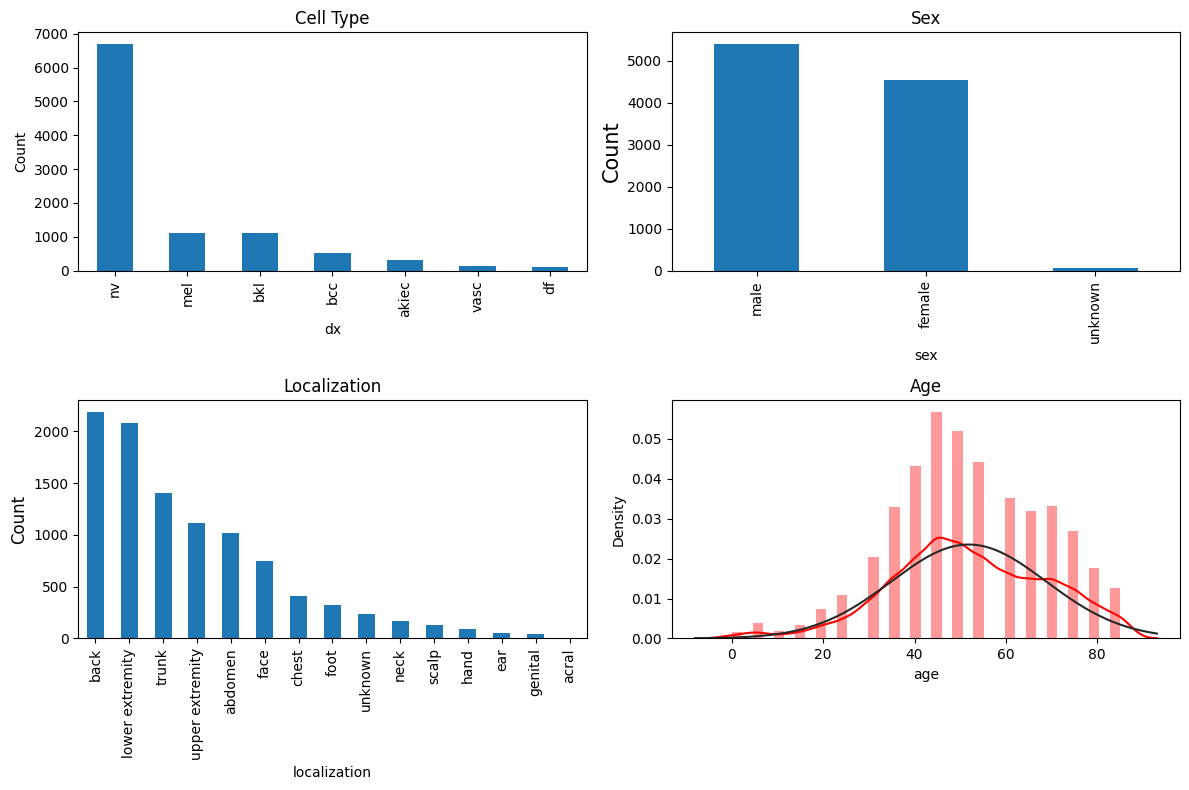

In [4]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

### Distribution of data into various classes 

In [5]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


### Balance data.

In [6]:

# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

print(df_0.shape)

(327, 8)


In [7]:
n_samples=6500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)
print(df_0_balanced.shape)


(6500, 8)


In [8]:
#Combined back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

### Classes should be balanced now.

In [9]:
#Check the distribution. All classes should be balanced now.
print(skin_df_balanced['label'].value_counts())

label
0    6500
1    6500
2    6500
3    6500
4    6500
5    6500
6    6500
Name: count, dtype: int64


## Read images based on image ID from the CSV file

In [10]:
#This is the safest way to read images as it ensures the right image is read for the right ID
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/kaggle/input/skin-cancer-lesions-inzip', '*', '*.jpg'))}

### Define the path and add as a new column

In [11]:
#Define the path and add as a new column

skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [12]:
skin_df_balanced.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,path,image
9789,HAM_0003136,ISIC_0026645,akiec,histo,65.0,male,back,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[150, 112, 104], [160, 125, 117], [162, 127,..."
9957,HAM_0006587,ISIC_0025780,akiec,histo,70.0,male,face,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[139, 79, 89], [131, 68, 72], [131, 66, 67],..."
9793,HAM_0005505,ISIC_0024450,akiec,histo,50.0,male,upper extremity,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[92, 59, 60], [126, 91, 92], [156, 120, 119]..."
9758,HAM_0003455,ISIC_0027896,akiec,histo,75.0,male,hand,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[197, 141, 171], [204, 148, 174], [201, 142,..."
9875,HAM_0005459,ISIC_0029268,akiec,histo,85.0,male,upper extremity,0,/kaggle/input/skin-cancer-lesions-inzip/HAM100...,"[[[200, 176, 199], [206, 178, 201], [203, 171,..."


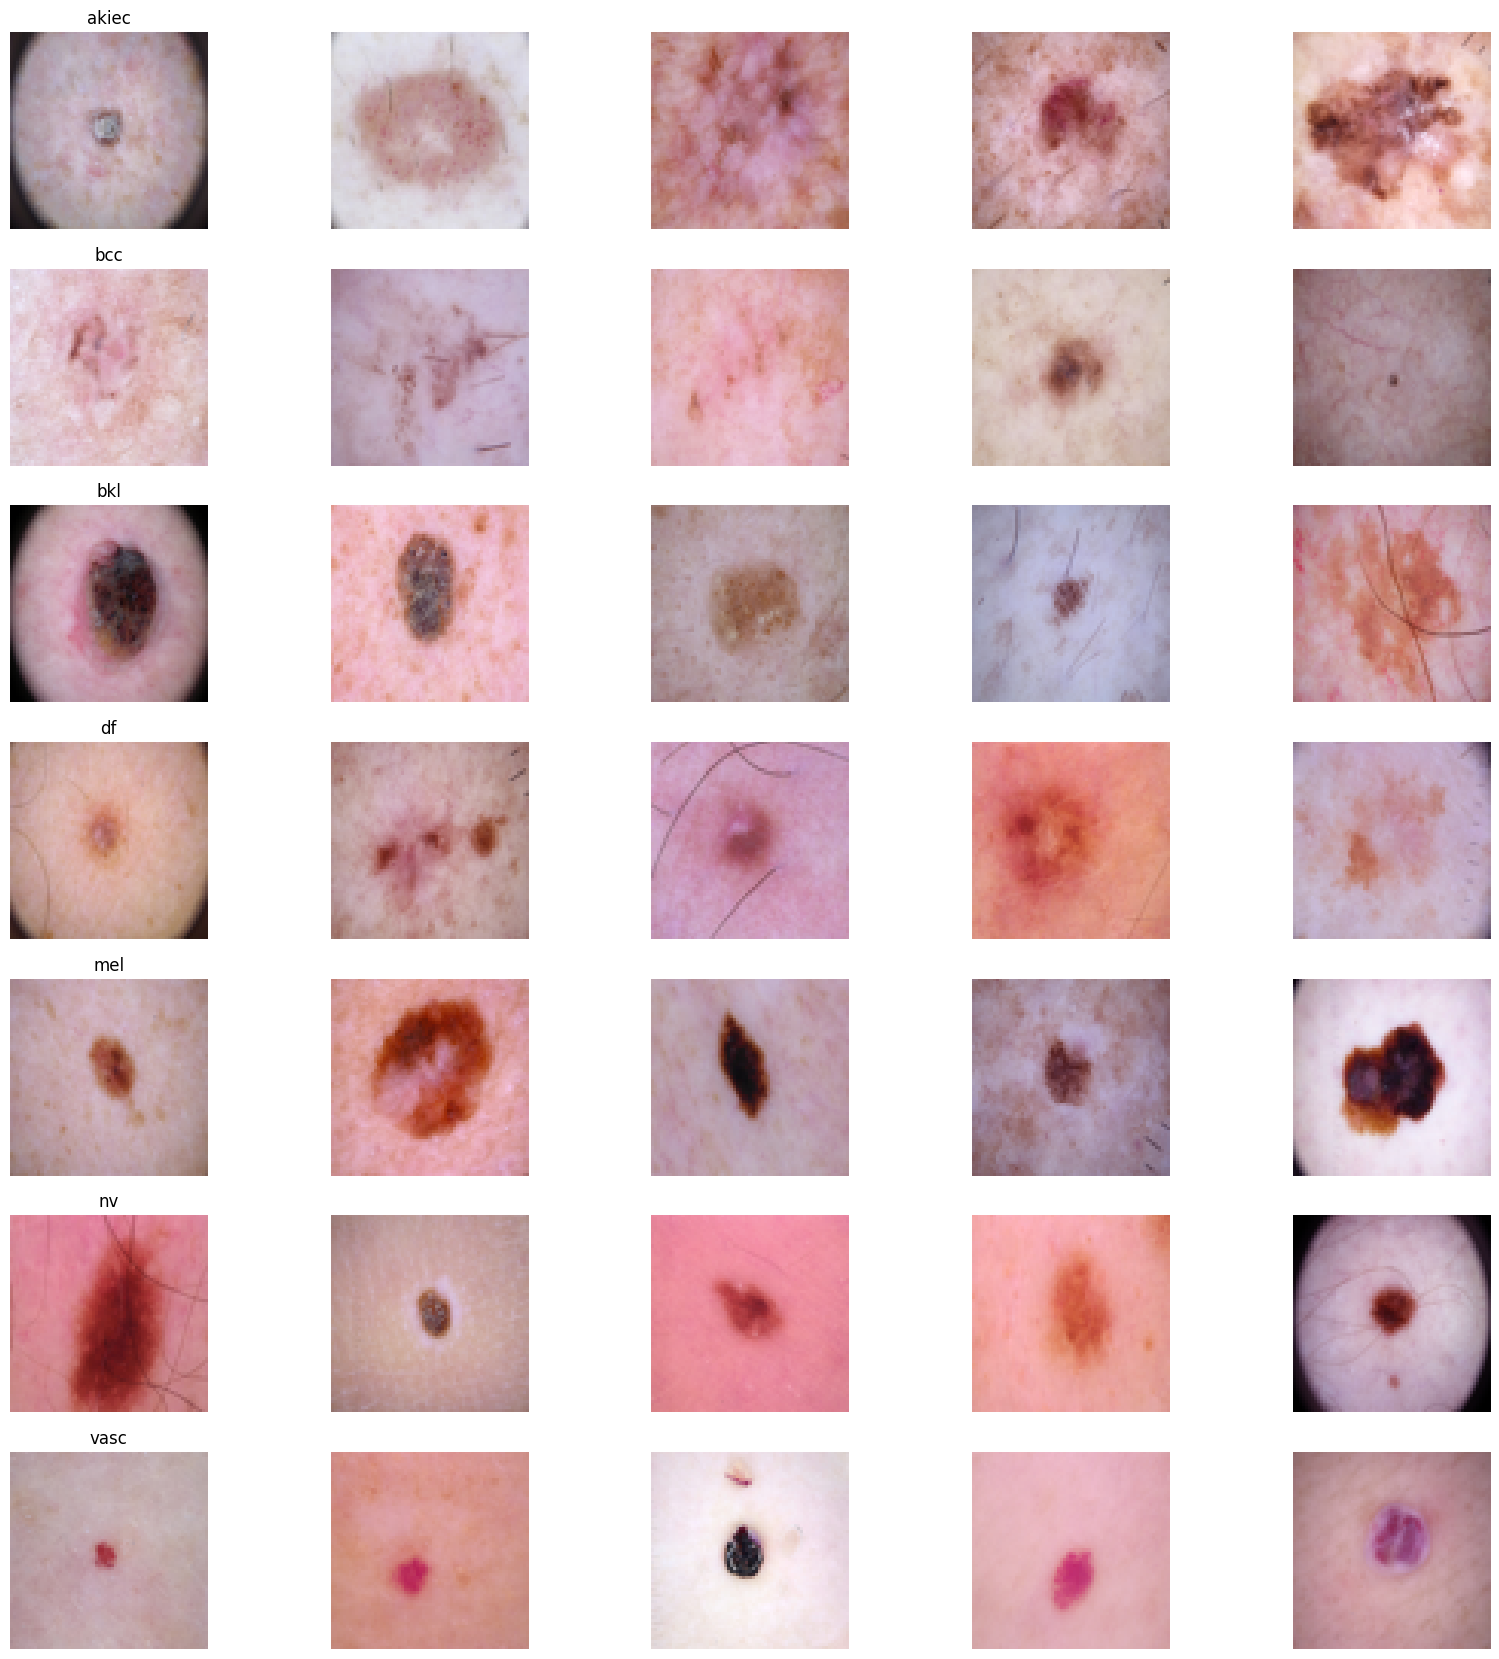

In [13]:
import matplotlib.pyplot as plt

n_samples = 5  # number of samples for plotting
# Plotting
fig, m_axs = plt.subplots(7, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.show()


### Convert dataframe column of images into numpy array

In [14]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

In [15]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

In [16]:
num_classes = 7

In [17]:
#-------------------------------model------------------------------
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Normalization
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [18]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Define input layer
input_layer = Input(shape=(65, 65, 3))

# Cast to float32
cast_to_float32 = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(input_layer)

# Normalization layer
normalization = Normalization()(cast_to_float32)

# Convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(normalization)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)

# Max pooling layer
pooling = MaxPooling2D(pool_size=(2, 2))(conv2)

# Dropout layer
dropout = Dropout(0.25)(pooling)

# Flatten layer
flatten = Flatten()(dropout)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten)
dense2 = Dense(7, activation='softmax')(dense1)  # Assuming 7 classes

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=dense2)



# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 65, 65, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 63, 63, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,230 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 7 (32.00 B)

### Compile the model

In [19]:
# Compile the model with Adam optimizer and learning rate
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size = 32,
    validation_data=(x_test, y_test))

Epoch 1/15
  19/1067 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.1604 - loss: 3.1125

I0000 00:00:1713083531.122122      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713083531.141995      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5083 - loss: 1.2994

W0000 00:00:1713083546.743285      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.5085 - loss: 1.2990 - val_accuracy: 0.8590 - val_loss: 0.3936
Epoch 2/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8896 - loss: 0.3163 - val_accuracy: 0.9339 - val_loss: 0.1923
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9519 - loss: 0.1434 - val_accuracy: 0.9590 - val_loss: 0.1385
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9706 - loss: 0.0838 - val_accuracy: 0.9685 - val_loss: 0.1107
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9801 - loss: 0.0596 - val_accuracy: 0.9819 - val_loss: 0.0814
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9842 - loss: 0.0510 - val_accuracy: 0.9786 - val_loss: 0.0785
Epoch 7/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9863 - loss: 0.0403 - val_accuracy: 0.9780 - val_loss: 0.0873
Epoch 8/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9959 - loss: 0.01

### Download Model

In [20]:
# Save the model
model.save("model.h5")

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=7)
y_test_cat = to_categorical(y_test, num_classes=7)

# Define input layer
input_layer = Input(shape=(65, 65, 3))

# Cast to float32
cast_to_float32 = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32))(input_layer)

# Normalization layer
normalization = Normalization()(cast_to_float32)

# Convolutional layers
conv1 = Conv2D(32, (3, 3), activation='relu')(normalization)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)

# Max pooling layer
pooling = MaxPooling2D(pool_size=(2, 2))(conv2)

# Dropout layer
dropout = Dropout(0.25)(pooling)

# Flatten layer
flatten = Flatten()(dropout)

# Dense layers
dense1 = Dense(128, activation='relu')(flatten)
dense2 = Dense(7, activation='softmax')(dense1)  # Assuming 7 classes

# Create the model
model = tf.keras.Model(inputs=input_layer, outputs=dense2)



# Print model summary
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 65, 65, 3)      │             7 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 63, 63, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,393,230 (28.20 MB)

 Trainable params: 7,393,223 (28.20 MB)

 Non-trainable params: 7 (32.00 B)

In [22]:
# Compile the model
# Compile the model with Adam optimizer and learning rate
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size = 32,
    validation_data=(x_test, y_test))

Epoch 1/15
  13/1067 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.1596 - loss: 4.3273

W0000 00:00:1713083704.275143      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4890 - loss: 1.4193

W0000 00:00:1713083718.352490      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.4892 - loss: 1.4189 - val_accuracy: 0.7516 - val_loss: 0.6399
Epoch 2/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.8531 - loss: 0.4160 - val_accuracy: 0.9345 - val_loss: 0.2033
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9372 - loss: 0.1795 - val_accuracy: 0.9556 - val_loss: 0.1392
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9661 - loss: 0.1012 - val_accuracy: 0.9715 - val_loss: 0.0955
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9712 - loss: 0.0852 - val_accuracy: 0.9627 - val_loss: 0.1263
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9807 - loss: 0.0580 - val_accuracy: 0.9748 - val_loss: 0.0986
Epoch 7/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9824 - loss: 0.0530 - val_accuracy: 0.9802 - val_loss: 0.0862
Epoch 8/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9858 - loss: 0.04

In [24]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
import keras

print("Keras version:", keras.__version__)


TensorFlow version: 2.15.0
Keras version: 3.0.5


In [25]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

 57/356 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

W0000 00:00:1713083872.125800      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


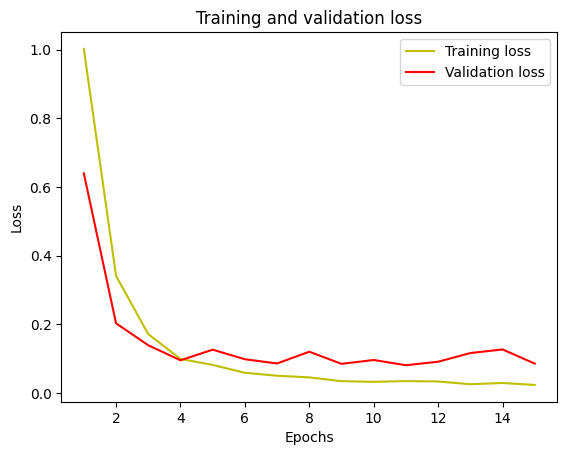

In [26]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

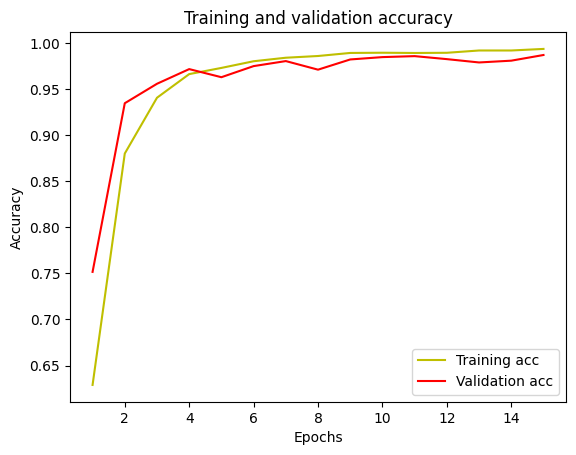

In [27]:

#plot the training and validation accuracy and loss at each epoch
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training acc')
plt.plot(epochs, val_loss, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


### Confusion Matrix

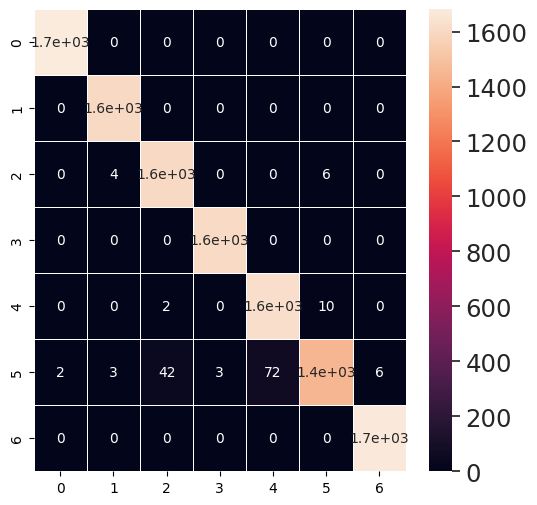

In [29]:
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax, annot_kws={"size": 10})

plt.show()

### Classification Report

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1681
           1       1.00      1.00      1.00      1596
           2       0.97      0.99      0.98      1607
           3       1.00      1.00      1.00      1608
           4       0.96      0.99      0.97      1637
           5       0.99      0.92      0.95      1573
           6       1.00      1.00      1.00      1673

    accuracy                           0.99     11375
   macro avg       0.99      0.99      0.99     11375
weighted avg       0.99      0.99      0.99     11375



(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 ]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.02, '0.02'),
  Text(0, 0.04, '0.04'),
  Text(0, 0.06, '0.06'),
  Text(0, 0.08, '0.08'),
  Text(0, 0.1, '0.10')])

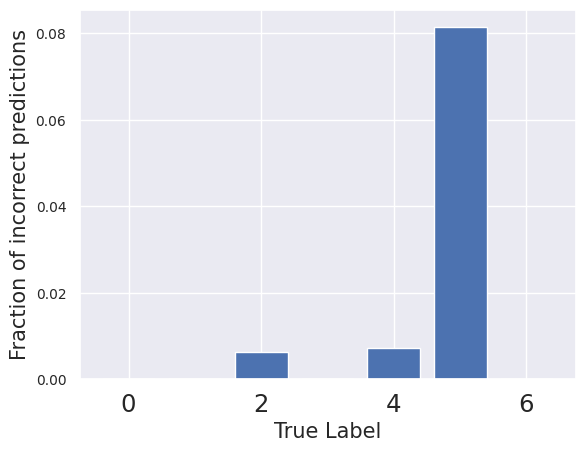

In [31]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label',fontsize=15)
plt.ylabel('Fraction of incorrect predictions',fontsize=15)
# Decrease label size
plt.yticks(fontsize=10)


## -------------------------------VGG16 model------------------------------


In [39]:
#-------------------------------VGG16 model------------------------------
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

In [42]:
# Define input layer
input_layer = Input(shape=(65, 65, 3))

# Load pre-trained VGG16 model
pre_trained_model = VGG16(input_shape=(65, 65, 3), include_top=False, weights='imagenet')


In [43]:
# Freeze layers in pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Get the output of the pre-trained VGG16 model
output_vgg16 = pre_trained_model(input_layer)

In [44]:
# Flatten the output of the pre-trained model
flatten_layer = Flatten()(output_vgg16)

# Add fully connected layers
dense1 = Dense(128, activation='relu')(flatten_layer)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(7, activation='softmax')(dropout)  # Assuming 7 classes

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,863 (57.14 MB)

 Trainable params: 263,175 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [45]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test)
)

Epoch 1/15
  13/1067 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.1407 - loss: 2.1754

W0000 00:00:1713084175.086246      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4191 - loss: 1.5058

W0000 00:00:1713084193.815171      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713084196.315462      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 36s 27ms/step - accuracy: 0.4192 - loss: 1.5057 - val_accuracy: 0.6422 - val_loss: 0.9815
Epoch 2/15
   9/1067 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5400 - loss: 1.1283

W0000 00:00:1713084203.975379      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.5924 - loss: 1.0713 - val_accuracy: 0.7087 - val_loss: 0.8068
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.6531 - loss: 0.9185 - val_accuracy: 0.7513 - val_loss: 0.7098
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6884 - loss: 0.8265 - val_accuracy: 0.7832 - val_loss: 0.6020
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7148 - loss: 0.7458 - val_accuracy: 0.7911 - val_loss: 0.5570
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7425 - loss: 0.6907 - val_accuracy: 0.8177 - val_loss: 0.5114
Epoch 7/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7517 - loss: 0.6525 - val_accuracy: 0.8242 - val_loss: 0.4967
Epoch 8/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7625 - loss: 0.6185 - val_accuracy: 0.8469 - val_loss: 0.4458
Epoch 9/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7775 - loss: 0.58

In [46]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1)

 13/356 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step 

W0000 00:00:1713084488.268369      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step


W0000 00:00:1713084493.607067      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [47]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [48]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1681
           1       0.90      0.93      0.92      1596
           2       0.84      0.71      0.77      1607
           3       0.99      0.99      0.99      1608
           4       0.78      0.84      0.81      1637
           5       0.83      0.79      0.81      1573
           6       0.99      1.00      0.99      1673

    accuracy                           0.89     11375
   macro avg       0.89      0.89      0.89     11375
weighted avg       0.89      0.89      0.89     11375



## -------------------------------MobileNet model------------------------------


In [49]:
#-------------------------------MobileNet model------------------------------
from tensorflow.keras.applications import MobileNet

In [62]:
# Define input layer
input_layer = Input(shape=(65, 65, 3))

# Load pre-trained MobileNet model
pre_trained_model = MobileNet(input_shape=(65, 65, 3), include_top=False, weights='imagenet')

# Freeze layers except the last convolutional block
for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False

# Get the output of the pre-trained MobileNet model
output_mobilenet = pre_trained_model(input_layer)

/tmp/ipykernel_34/2975933204.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pre_trained_model = MobileNet(input_shape=(65, 65, 3), include_top=False, weights='imagenet')


In [63]:
# Flatten the output of the pre-trained model
flatten_layer = Flatten()(output_mobilenet)

# Add fully connected layers
dense1 = Dense(128, activation='relu')(flatten_layer)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(7, activation='softmax')(dropout)  # Assuming 7 classes


In [64]:
# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Print model summary
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 2, 2, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,754,183 (14.32 MB)

 Trainable params: 1,575,943 (6.01 MB)

 Non-trainable params: 2,178,240 (8.31 MB)

In [65]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

 45/356 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

W0000 00:00:1713085093.258063      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


W0000 00:00:1713085097.074760      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


## -------------------------------DenseNet121 model------------------------------


In [54]:
#-------------------------------DenseNet121 model------------------------------
from tensorflow.keras.applications import DenseNet121

In [55]:
# Define input layer
input_layer = Input(shape=(65, 65, 3))

# Load pre-trained DenseNet121 model
pre_trained_model = DenseNet121(input_shape=(65, 65, 3), include_top=False, weights='imagenet')

# Freeze layers except the last convolutional block
for layer in pre_trained_model.layers[:-4]:
    layer.trainable = False

# Get the output of the pre-trained DenseNet121 model
output_densenet = pre_trained_model(input_layer)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [56]:
# Flatten the output of the pre-trained model
flatten_layer = Flatten()(output_densenet)

# Add fully connected layers
dense1 = Dense(128, activation='relu')(flatten_layer)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(7, activation='softmax')(dropout)  # Assuming 7 classes

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

In [57]:
# Print model summary
model.summary()


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 65, 65, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,562,823 (28.85 MB)

 Trainable params: 564,231 (2.15 MB)

 Non-trainable params: 6,998,592 (26.70 MB)

In [58]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(x_test, y_test)
)

Epoch 1/15
   7/1067 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.2186 - loss: 3.2175

W0000 00:00:1713084713.999113      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4924 - loss: 1.3910

W0000 00:00:1713084743.685061      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713084754.898932      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 86s 53ms/step - accuracy: 0.4925 - loss: 1.3908 - val_accuracy: 0.7711 - val_loss: 0.6192
Epoch 2/15
   5/1067 ━━━━━━━━━━━━━━━━━━━━ 27s 26ms/step - accuracy: 0.6578 - loss: 0.9161

W0000 00:00:1713084770.275282      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.6952 - loss: 0.7935 - val_accuracy: 0.8266 - val_loss: 0.4454
Epoch 3/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.7600 - loss: 0.6246 - val_accuracy: 0.8714 - val_loss: 0.3506
Epoch 4/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.7909 - loss: 0.5330 - val_accuracy: 0.8867 - val_loss: 0.2974
Epoch 5/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - accuracy: 0.8178 - loss: 0.4629 - val_accuracy: 0.9048 - val_loss: 0.2614
Epoch 6/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8377 - loss: 0.4124 - val_accuracy: 0.9116 - val_loss: 0.2355
Epoch 7/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8460 - loss: 0.3765 - val_accuracy: 0.9193 - val_loss: 0.2200
Epoch 8/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8580 - loss: 0.3539 - val_accuracy: 0.9349 - val_loss: 0.1841
Epoch 9/15
1067/1067 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.8770 - loss: 0.31

In [59]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

 10/356 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step

W0000 00:00:1713085069.185939      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


356/356 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step


W0000 00:00:1713085082.452716      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [60]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

356/356 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


In [61]:
from sklearn.metrics import confusion_matrix, classification_report
# Generate classification report
report = classification_report(y_true, y_pred_classes)
print(report)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1681
           1       0.99      1.00      0.99      1596
           2       0.92      0.96      0.94      1607
           3       1.00      1.00      1.00      1608
           4       0.89      0.96      0.92      1637
           5       0.96      0.83      0.89      1573
           6       1.00      1.00      1.00      1673

    accuracy                           0.96     11375
   macro avg       0.96      0.96      0.96     11375
weighted avg       0.96      0.96      0.96     11375

